# Plotting data with matplotlib

Matplotlib is a powerful but unintuitive plotting library.
The best way to learn Matplotlib is to browse through galleries until you find something you like, and copy it. But to make sense of what you read, you need to know the basic structure of a plot, which is laid out in section 1.
Then, to customize your plots you’ll need to make frequent use of Google, [Stack Overflow](https://stackoverflow.com/questions/tagged/matplotlib), the [matplotlib gallery](https://matplotlib.org/2.1.0/gallery/index.html), and maybe if things get desperate look at the documentation. The rest of this notebook is a gallery — scroll through the pictures, and if you see something you like then read the code. The [Python Graph Gallery](https://python-graph-gallery.com/) is also a great source of inspiration, but most of its plots use a Matplotlib wrapper called [seaborn](https://seaborn.pydata.org/examples/index.html), which is yet another thing to learn.

#### Contents

* [0. Preamble](#0.-Preamble)
* [1. Code structure for plotting](#1.-Code-structure-for-plotting)
* [2. Gallery](#2.-Gallery)
  * [2.1 MULTIPANEL BAR CHART](#2.1-MULTIPANEL-BAR-CHART)
  * [2.2 HISTOGRAM AND DENSITY PLOT](#2.2-HISTOGRAM-AND-DENSITY-PLOT)
  * [2.3 LINE PLOTS + LEGEND](#2.3-LINE-PLOTS-+-LEGEND)
  * [2.4 SCATTER PLOT + DISCRETE COLOUR SCALE](#2.4-SCATTER-PLOT-+-DISCRETE-COLOUR-SCALE)
  * [2.5 MULTIPANEL PLOT AGAIN](#2.5-MULTIPANEL-PLOT-AGAIN)
  * [2.6 HEATMAP + CONTINUOUS COLOUR SCALE](#2.6-HEATMAP-+-CONTINUOUS-COLOUR-SCALE)

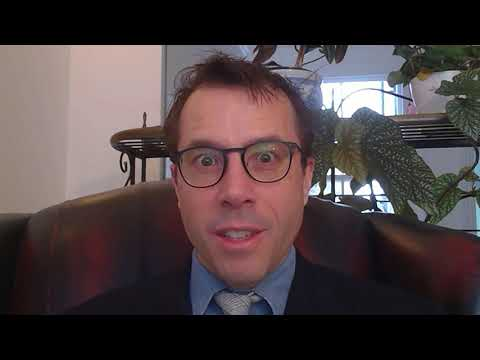

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('UO-d42qQqZU', width=560, height=315)

## 0. Preamble

Here are the standard imports for nearly any piece of data handling work:

In [ ]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

The plots in this notebook are all based on the stop-and-search dataset explored in Notebook 3.

In [13]:
import os.path
if os.path.exists('stop-and-search.csv'):
    print("file already downloaded")
else:
    !wget "https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/stop-and-search.csv"
stopsearch = pandas.read_csv('stop-and-search.csv')

file already downloaded


## 1. Code structure for plotting

Here is the general structure of plot code. I find it helpful to build up my plot step by step, adding
pieces in the order listed here, and checking at each step what the plot looks like. If you add everything
all in one go, chances are it won’t work and you won’t know which bit went wrong.

```python
# First, prepare the data and put it into a dataframe

# Get the overall Figure object (used for some overall customization)
# and Axes object (used for the actual plotting)
# Set figure size and other style parameters
fig,ax = plt.subplots(figsize=(x,y), ...)

# 1. Draw data points / bars / curves etc. onto ax
# 2. Configure limits and colour scales
# 3. Add annotations, text, arrows, etc.
# 4. Configure the grid, tick location, tick labels and format
# 5. Legend, axis labels, titles

# Save as pdf or svg or png, depending on the destination
plt.savefig('myplot.pdf', transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
```

Here's a very simple example.

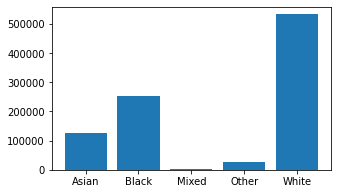

In [22]:
df = stopsearch.groupby('officer_defined_ethnicity').apply(len).reset_index(name='n')

fig,ax = plt.subplots(figsize=(5,3))
ax.bar(df['officer_defined_ethnicity'], df['n'])
plt.show()

It's usually more interesting to produce plots consisting of one or more subplots. The code to produce this starts with
```
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3)
```
which gives us thee Axes objects, once for each subplot, which we can then draw on using `ax1.bar`, `ax2.bar` and so on. The full code is in the gallery below.

![multipanel plot](res/plot0.png)

You’ll also see plenty of code samples which use commands like `plt.barh` or `plt.yticks`. That’s old-style
‘stateful’ code, where matplotlib tries to work out which subplot you’re currently drawing on — it
works fine if you only have one subplot, but it’s confusing when you have multiple subplots. Matplotlib
documentation advises that for more complex plots you should get the Axes object first and then use
`ax.barh` or `ax.set_yticks`.

## 2. Gallery

### 2.1 MULTIPANEL BAR CHART

Here’s the code behind our multipanel plot, shown above. Note the line
```
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, sharey=True)
```
which asks for three subplots in a row, and says that their $y$ scales are to be shared. Matplotlib picks
the scales automatically to fit the objects drawn onto a subplot, and `sharey=True` means that all three
subplots get their scales adjusted. It also means that the tick marks are only shown on one of the three
subplots.

Your computer scientists, so you should produce the three plots with a for loop, rather than by copying the plot command three times!

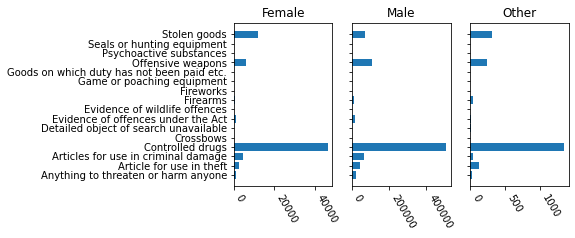

In [31]:
x = stopsearch.groupby(['object_of_search','gender']).apply(len)
df = x.unstack(fill_value=0).reset_index().rename_axis(None, axis=1)

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(6,3), sharey=True)

# 1. Draw three histograms, one in each subplot
for (ax,eth) in zip([ax1,ax2,ax3], ['Female','Male','Other']):
    ax.barh(np.arange(len(df)), df[eth])

# 2. We've already specified, through sharey=True, that the three plots
# share a common y-axis. Nothing else to set.

# 3. No annotations needed
    
# 4. Configure ticks: labels on the y-axis, rotated ticks on x-axis
ax1.set_yticks(np.arange(len(df)))
ax1.set_yticklabels(df.object_of_search)

for ax in (ax1,ax2,ax3):
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(-60)
        lbl.set_ha('left')

# 5. Titles
for ax,eth in zip([ax1,ax2,ax3], ['Female','Male','Other']):
    ax.set_title(eth)

#plt.savefig('res/plot0.png', transparent=False, bbox_inches='tight', pad_inches=0.1)    
plt.show()

### 2.2 HISTOGRAM AND DENSITY PLOT

This plot shows two graphics superimposed, a histogram (i.e. a bar
chart based on binned counts), and a smooth curve for the density. To produce the smooth curve we
can use a generic smoother such as `scipy.stats.gaussian_kde`, which takes the underlying data and
returns a function, and then apply this function to evenly-spaced values along the $x$-axis to generate
the points to be plotted.

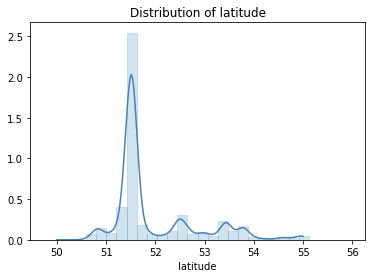

In [32]:
x = stopsearch.location_latitude
x = x[~pandas.isna(x)]   # remove missing values

import scipy.stats
# Smoothing is slow, and it produces just as good results on a subset
density = scipy.stats.gaussian_kde(np.random.choice(x,50000))

fig,ax = plt.subplots()
ax.hist(x, bins=30, density=True, alpha=0.2, edgecolor='steelblue')
xsample = np.linspace(50,55,200)
ax.plot(xsample, density(xsample), color='steelblue')
ax.set_xlabel('latitude')
ax.set_title('Distribution of latitude')
plt.show()

### 2.3 LINE PLOTS + LEGEND

There are several techniques being used in this example.
* The dataset as loaded stores the datetime as a string, which isn’t very useful. Here I convert it
to Python [datetime](https://docs.python.org/3/library/datetime.html#datetime.datetime), and Matplotlib knows how to display it sensibly. Pandas has lots of fast vectorized operations for handling strings and timestamps, which can help.
* The two plot commands both have a label. Matplotlib remembers the styling that was applied
for each label, and can generate an appropriate legend.
* The plot sets `figure.figsize` to be (5, 1.5). Technically the units are in inches, but the actual output depends on what dpi your computer thinks it's using.
* The text size is set with `fontsize`, measured in points (1/72 inch).

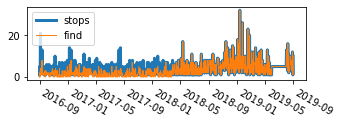

In [154]:
df = stopsearch.loc[stopsearch.force=='cambridgeshire', ['datetime','outcome']].copy()
df['outcome'] = np.where(df.outcome=='False','nothing','find')
df['date'] = pandas.to_datetime(df.datetime.str.slice(stop=10), format='%Y-%m-%d')

# Number of events per date, sorted by timestamp
# (if timestamps were unsorted, the line would wiggle backwards and forwards)
df = df.groupby(['date','outcome']).apply(len).unstack(fill_value=0).reset_index()
df = df.iloc[np.argsort(df.date)]

fig,ax = plt.subplots(figsize=(5,1.5))
ax.plot(df.date, df.find + df.nothing, label='stops', linewidth=3)
ax.plot(df.date, df.find, label='find', linewidth=1)
ax.legend()

# Some magic to improve tick labels for an entire figure
fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')
plt.show()

### 2.4 SCATTER PLOT + DISCRETE COLOUR SCALE

For scatter plots, use [`Axes.scatter`](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.scatter.html). This lets you specify the `marker`, the size `s`, and the color `c`. Here I'm iterating through the different police forces, and calling $\textsf{scatter}$ each time. I chose an appropriate [colour scale](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) using
```
c = plt.get_cmap('Pastel1', n))
```
This gives a function that we can call to get actual colour values. In this case it's a discrete colour scale with values $c(0),\dots,c(n-1)$.

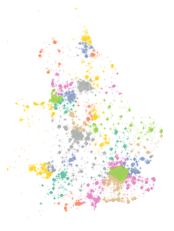

In [33]:
# There’s no point plotting more data than there are pixels on the output
df = stopsearch.iloc[np.random.choice(len(stopsearch), size=100000)]

fig,ax = plt.subplots()

cols = plt.get_cmap('Set2', len(np.unique(df.force)))
for i,police_force in enumerate(np.unique(df.force)):
    want_rows = (df.force == police_force)
    x,y = df.location_longitude[want_rows], df.location_latitude[want_rows]
    # Set the size, alpha, and colour of the points
    ax.scatter(x, y, s=1, alpha=.1, color=cols(i))

# Set the aspect ratio, based on the UK’s average latitude
ax.set_aspect(1/np.cos(54/360*2*np.pi))

# Pick coordinates to show (I chose these after seeing the plot first)
ax.set_xlim([-5,2])
ax.set_ylim([50.2, 55.8])

# Get rid of the tick marks and the outer frame
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.show()

### 2.5 MULTIPANEL PLOT AGAIN

Here is another multipanel plot, also called a _facet plot_ or _small multiples_ plot.
[According to](https://en.wikipedia.org/wiki/Small_multiple) the plotting
guru Edward Tufte,
> At the heart of quantitative reasoning is a single question: Compared to what? Small
> multiple designs, multivariate and data bountiful, answer directly by visually enforcing
> comparisons of changes, of the differences among objects, of the scope of alternatives.
> For a wide range of problems in data presentation, small multiples are the best design
> solution.

We also showed a multipanel plot at the top of this notebook.
There are actually two types of facet plot:
* We might want a grid of plots, either 1d or 2d. To get a grid of Axes objects, use
```
fig,axes = plt.subplots(nrows,vncols)
```
This will return either a vector of axes or an array of axes, according to nrows and ncols.
* We might want a sequence of plots which is allowed to wrap over several lines. For this, decide
how many rows and columns we’ll want in total, then call add_subplot to add each facet one
by one.
```
fig = plt.figure()
ax = fig.add_subplot(nrows, ncols, i) # i starts at 1
```

Two other things worth mentioning in this code.

* The line `with plt.rc_context({...})` lets us specify a [whole host of display options](https://matplotlib.org/3.1.0/tutorials/introductory/customizing.html).

* I first convert all the datetimes into Unix timestamps
(integers, counting the number of seconds since Thursday 1970-01-01 00:00:00), and then I do simple
integer arithmetic to get dates and weekdays. I find this easier than wading through library documentation
about datetime utility functions, and it’s also much faster because it’s simple vectorized numpy
expressions.

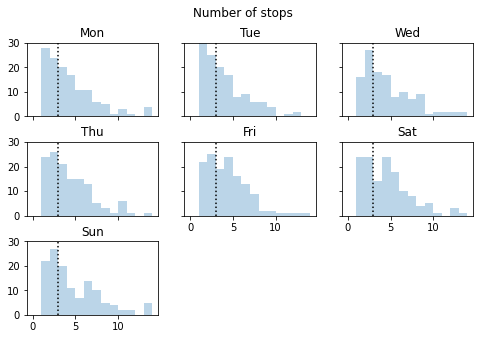

In [155]:
df = stopsearch.loc[stopsearch.force=='cambridgeshire'].copy()
df['date'] = pandas.to_datetime(df.datetime.str.slice(stop=10), format='%Y-%m-%d')
df['weekday'] = df.date.dt.isocalendar()['day'] - 1 # 0=Mon, 6=Sun

# Get the number of stops, grouped by date. Also include the weekday variable,
# which is redundant, but we'll use it the next step to plot a histogram per day
# of week.
df2 = df.groupby(['date','weekday']).apply(len).reset_index(name='n')

with plt.rc_context({'figure.subplot.hspace':0.35}):
    fig = plt.figure(figsize=(8,5))

for i, weekday in enumerate(range(7)):
    ax = fig.add_subplot(3, 3, i+1)
    # 1. Draw the data
    ax.hist(df2.loc[df2.weekday==weekday,'n'].values, bins=range(15), alpha=.3)
    # 2. Configure limits
    ax.set_ylim([0,30])
    # 3. Add annotations
    ax.axvline(x=np.median(df2.n), linestyle='dotted', color='black')
    # 4. Configure ticks
    if i < 4: ax.set_xticklabels([])
    if (i % 3) != 0: ax.set_yticklabels([])
    # 5. Legend, axis, titles
    weekday_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    ax.set_title(weekday_names[weekday])

fig.suptitle('Number of stops')
plt.show()

### 2.6 HEATMAP + CONTINUOUS COLOUR SCALE

This plot uses [`Axes.imshow`](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html) to draw a heatmap. This takes an array, and treats it as pixels to be coloured. We can tell it what colour scale to use with `cmap`, and control the limits with `vmin` and `vmax`, and show the scale with `plt.colorbar`.

It's a bit of a hassle working with `imshow` because matplotlib just sees the data as an array, and we have to tell it explicitly what the rows and columns mean, using the `extent` argument. If we have a full dataset, as we do here, it's much easier to use [`Axes.bin2d`](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.hist2d.html).

This plot suggests there's some issue with the data. It's worth investigating what's going on in that one day of the year!

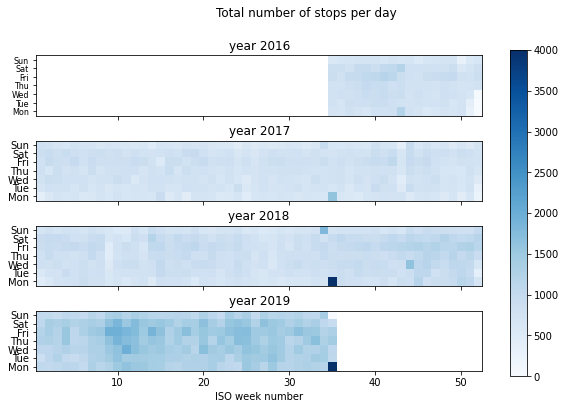

In [161]:
df = stopsearch.copy()

# Datetime operations are always a mystery, and need frequent documentation checks.
df['date'] = pandas.to_datetime(df.datetime.str.slice(stop=10), format='%Y-%m-%d')
df2 = df.date.dt.isocalendar() # gets the year, week of year, day of week (mon=1, sun=7)
for k in ['year','week','day']: df[k] = df2[k]

x = df.groupby(['year','day','week']).apply(len)

years = x.index.levels[0]

fig,axes = plt.subplots(len(years),1, figsize=(10,6), sharex=True, sharey=True)
for y,ax in zip(years, axes):
    xy = x.loc[y].unstack(fill_value=0)
    weeks = xy.columns
    im = ax.imshow(xy, origin='lower', extent=(min(weeks)-.5, max(weeks)+.5, 0.5, 7.5), 
              cmap='Blues', vmin=0, vmax=4000)
    ax.set_title(f"year {y}")

# Only need to set the xlim for one axis: we used sharex=True, so they all use the same
weeks = x.index.levels[2]
axes[0].set_xlim(min(weeks)-.5, max(weeks)+.5)

axes[0].set_yticks(np.arange(1,8))
axes[0].set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=8)
axes[-1].set_xlabel('ISO week number')

plt.colorbar(im, ax=axes)

fig.suptitle('Total number of stops per day')
plt.show()